In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, GlobalAveragePooling2D
import os
import cv2
import pickle
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model


from imblearn.under_sampling import RandomUnderSampler
from keras.utils.np_utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.1
#session = tf.compat.v1.Session(config=config)

In [2]:
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

# Import models from sources

In [3]:
dataPath = "../../data/OCT/OCT2017/"

In [4]:
labels_available = os.listdir(os.path.join(dataPath, "train"))
print("Total Number of Classes Detected :",len(labels_available))

labels_list = ['NORMAL',"CNV","DME","DRUSEN"]

Total Number of Classes Detected : 4


In [6]:
images=[]
y_trn=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "train", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        images.append(cv2.imread(os.path.join(xPath, y)))
        y_trn.append(labels_list.index(x))
    print(x ,end=" ")

NORMAL CNV DME DRUSEN 

In [7]:
x_val=[]
y_val=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "val", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        x_val.append(cv2.imread(os.path.join(xPath, y)))
        y_val.append(labels_list.index(x))
    print(x ,end=" ")

NORMAL CNV DME DRUSEN 

In [5]:
def resizeIm(im, size):
    if im.shape[2] == 1:
        im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
    return cv2.resize(im, size)

def resizeIms(x, size):
    return np.array(list(map(lambda im: resizeIm(im, size), x)))

## Train for Xception
Modify model to classifiy just the number of desired categories

In [6]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

# create the base pre-trained model
xceptionNetModel = Xception(weights='imagenet')

In [7]:
x = xceptionNetModel.output
# and a logistic layer -- let's say we have 4 classes
predictions = Dense(len(labels_list), activation='softmax')(x)

# this is the model we will train
xceptionNet = Model(inputs=xceptionNetModel.input, outputs=predictions)
#xceptionNet.summary()

In [8]:
print(f"Xception model occupied: {keras_model_memory_usage_in_bytes(xceptionNet, batch_size=1) / 10**6} MB")

Xception model occupied: 274.841968 MB


Resize images to desired shape

In [10]:
xceptionSize = (299, 299)
X_train = resizeIms(images, xceptionSize)
X_val = resizeIms(x_val, xceptionSize)

In [11]:
y_train = to_categorical(y_trn,len(labels_list))
y_validation = to_categorical(y_val,len(labels_list))

In [10]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self,fraction, model):
        super(CustomCallback,self).__init__()
        self.fraction = fraction
        self.train_a = [];
        self.val_a =[];
        self.logPath = os.path.join(model, "log.txt")

        if not os.path.isdir(model):
            os.mkdir(model)

        with open(self.logPath,'w') as f:
            f.write('Starting of logging..\n')

        self.fig = plt.figure(figsize=(4,3))
        self.ax = plt.subplot(1,1,1)
        plt.ion()

    def on_train_begin(self,logs=None):
        self.fig.show()
        self.fig.canvas.draw()

    def on_train_end(self,logs=None):
        with open(self.logPath,'a') as f:
              f.write('End of logging..\n')
    
    def on_epoch_begin(self,epoch,logs=None):
        lr= tf.keras.backend.get_value(self.model.optimizer.lr)
        lr *= self.fraction
        tf.keras.backend.set_value(self.model.optimizer.lr,lr)
        with open(self.logPath,'a') as f:
            f.write('At epoch {:02d}, learning rate changed to {:.4f}\n'.format(epoch,lr))
    
    def on_epoch_end(self,epoch,logs=None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        self.train_a.append(train_acc)
        self.val_a.append(val_acc)
        with open(self.logPath,'a') as f:
            f.write('At epoch {:02d}, training accuracy: {:.3f}, validation accuracy: {:.3f}\n'.format(epoch,train_acc,val_acc))
        self.ax.clear()
        self.ax.plot(range(1+epoch),self.train_a,label="Training")
        self.ax.plot(range(1+epoch),self.val_a,label="Validation")
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('Accuracy')
        self.ax.legend()
        self.fig.canvas.draw()
        self.fig.show()

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Define hiperparameters

In [44]:
#xceptionNet.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
xceptionNet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

<ipython-input-12-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
557/557 [==============================] - 1250s 2s/step - loss: 0.0294 - accuracy: 0.9948 - val_loss: 0.0356 - val_accuracy: 1.0000
Epoch 2/30


<ipython-input-12-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


306/557 [===============>..............] - ETA: 9:20 - loss: 0.0280 - accuracy: 0.9951

KeyboardInterrupt: 

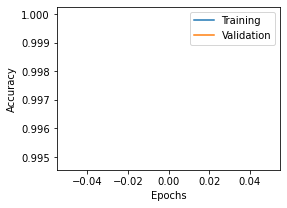

In [17]:
xceptionHist = xceptionNet.fit(X_train, y_train, epochs=30, validation_data = (X_val, y_validation), batch_size=150,
                    shuffle=True,
                    max_queue_size=20,
                    use_multiprocessing=True,
                    workers=5,
                   callbacks=[CustomCallback(fraction=0.9, model="Xception")])

In [22]:
xceptionHist.history

{'loss': [0.9846301078796387,
  0.5983363389968872,
  0.4142909646034241,
  0.31271785497665405,
  0.24276559054851532,
  0.19749096035957336,
  0.16444873809814453,
  0.13604038953781128,
  0.11632142215967178,
  0.09801001846790314,
  0.08458360284566879,
  0.07463981956243515,
  0.06700371950864792,
  0.06088167056441307,
  0.05482383072376251,
  0.05159606412053108,
  0.04856733977794647,
  0.045376040041446686,
  0.04310394078493118,
  0.04071763902902603,
  0.039301056414842606,
  0.037413157522678375,
  0.035869620740413666,
  0.03491583094000816,
  0.033987730741500854,
  0.032872606068849564,
  0.032120879739522934,
  0.03090815804898739,
  0.030536150559782982,
  0.030004046857357025],
 'accuracy': [0.8528221249580383,
  0.9322265386581421,
  0.9479541182518005,
  0.9561113715171814,
  0.9638733267784119,
  0.969491183757782,
  0.9738872051239014,
  0.9782713055610657,
  0.9815653562545776,
  0.9849791526794434,
  0.9874826073646545,
  0.9890996813774109,
  0.9900580048561096

In [16]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
xceptionNet.save("Xception/xception_30epochs_adam")

# It can be used to reconstruct the model identically.
#xception20Epochs = keras.models.load_model("Xception/xception_20epochs")

INFO:tensorflow:Assets written to: Xception/xception_30epochs_adam/assets


## OpticNet

In [27]:
opticNet = tf.keras.models.load_model('../Optic_net-4_classes-Kermany2018.hdf5')
#opticNet.summary()

In [28]:
opticNet.get_config().keys()
opticNet.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>

In [29]:
#opticNet.summary()
print(f"OpticNet model occupied: {keras_model_memory_usage_in_bytes(opticNet, batch_size=1) / 10**6} MB")

OpticNet model occupied: 842.014372 MB


In [31]:
opticNetsize = (224, 224)

X_train = resizeIms(images, opticNetsize)
X_val = resizeIms(x_val, opticNetsize)

y_train = to_categorical(y_trn,len(labels_list))
y_validation = to_categorical(y_val,len(labels_list))

In [32]:
opticNet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

<ipython-input-10-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/10
1670/1670 [==============================] - 1986s 1s/step - loss: 0.2894 - accuracy: 0.9157 - val_loss: 0.0780 - val_accuracy: 1.0000
Epoch 2/10


<ipython-input-10-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


1670/1670 [==============================] - 1936s 1s/step - loss: 0.1251 - accuracy: 0.9583 - val_loss: 0.0200 - val_accuracy: 1.0000
Epoch 3/10
1670/1670 [==============================] - 1935s 1s/step - loss: 0.1062 - accuracy: 0.9636 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 4/10
1670/1670 [==============================] - 1935s 1s/step - loss: 0.0863 - accuracy: 0.9708 - val_loss: 0.0525 - val_accuracy: 0.9688
Epoch 5/10
1670/1670 [==============================] - 1937s 1s/step - loss: 0.0700 - accuracy: 0.9760 - val_loss: 0.0362 - val_accuracy: 0.9688
Epoch 6/10
1670/1670 [==============================] - 1964s 1s/step - loss: 0.0565 - accuracy: 0.9813 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 7/10
1670/1670 [==============================] - 1967s 1s/step - loss: 0.0448 - accuracy: 0.9844 - val_loss: 0.0384 - val_accuracy: 0.9688
Epoch 8/10
1670/1670 [==============================] - 1975s 1s/step - loss: 0.0365 - accuracy: 0.9874 - val_loss: 0.0205 - val_accura

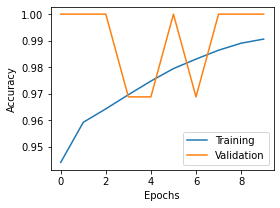

In [33]:
opticHist = opticNet.fit(X_train, y_train, epochs=10, validation_data =(X_val, y_validation), batch_size=50,
                    shuffle=True,
                    max_queue_size=20,
                    use_multiprocessing=True,
                    workers=5,
                   callbacks=[CustomCallback(fraction=0.9, model="OpticNet")])

In [ ]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
opticNet.save("OpticNet-71/opticnet_10epochs_adam")

# It can be used to reconstruct the model identically.
#opticNet5Epochs = keras.models.load_model("OpticNet-71/opticnet_5epochs")

## ResNet 50

In [17]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

resNetModel = ResNet50(weights='imagenet')
#resNetModel.summary()

In [18]:
x = resNetModel.output
# and a logistic layer -- let's say we have 4 classes
predictions = Dense(len(labels_list), activation='softmax')(x)

# this is the model we will train
resNet = Model(inputs=resNetModel.input, outputs=predictions)
#resNet.summary()

In [19]:
#resNet.summary()
print(f"ResNet50 model occupied: {keras_model_memory_usage_in_bytes(resNet, batch_size=1) / 10**6} MB")

ResNet50 model occupied: 174.12158 MB


In [20]:
size = (224, 224)

X_train = resizeIms(images, size)
X_val = resizeIms(x_val, size)

y_train = to_categorical(y_trn,len(labels_list))
y_validation = to_categorical(y_val,len(labels_list))

In [21]:
resNet.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

<ipython-input-10-797fd00c81c1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Epoch 1/30
835/835 [==============================] - 338s 384ms/step - loss: 1.1285 - accuracy: 0.7371 - val_loss: 1.3419 - val_accuracy: 0.4062
Epoch 2/30


<ipython-input-10-797fd00c81c1>:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


835/835 [==============================] - 320s 383ms/step - loss: 0.6913 - accuracy: 0.8415 - val_loss: 0.8842 - val_accuracy: 0.7188
Epoch 3/30
835/835 [==============================] - 319s 383ms/step - loss: 0.4793 - accuracy: 0.8913 - val_loss: 0.3519 - val_accuracy: 0.9688
Epoch 4/30
835/835 [==============================] - 319s 382ms/step - loss: 0.3230 - accuracy: 0.9328 - val_loss: 0.3366 - val_accuracy: 0.9375
Epoch 5/30
835/835 [==============================] - 320s 383ms/step - loss: 0.2455 - accuracy: 0.9471 - val_loss: 0.2220 - val_accuracy: 0.9688
Epoch 6/30
835/835 [==============================] - 319s 383ms/step - loss: 0.1962 - accuracy: 0.9554 - val_loss: 0.0877 - val_accuracy: 1.0000
Epoch 7/30
835/835 [==============================] - 320s 383ms/step - loss: 0.1620 - accuracy: 0.9625 - val_loss: 0.0716 - val_accuracy: 1.0000
Epoch 8/30
835/835 [==============================] - 320s 383ms/step - loss: 0.1370 - accuracy: 0.9678 - val_loss: 0.0692 - val_accura

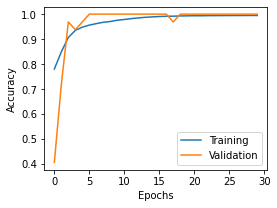

In [22]:
resnetHist = resNet.fit(X_train, y_train, epochs=30, validation_data = (X_val, y_validation), batch_size=100,
                    shuffle=True,
                    max_queue_size=20,
                    use_multiprocessing=True,
                    workers=5,
                   callbacks=[CustomCallback(fraction=0.9, model="ResNet")])

In [23]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
resNet.save("../Resnet50/resnet50_30epochs_adam")

# It can be used to reconstruct the model identically.
#resNet30Epochs = keras.models.load_model("Resnet50/resnet50_30epochs")

INFO:tensorflow:Assets written to: ../Resnet50/resnet50_30epochs_adam/assets


## Test models

Load test data

In [24]:
x_tst=[]
y_tst=[]
for x in labels_list:
    xPath = os.path.join(dataPath, "test", x)
    myPicList = os.listdir(xPath)
    for y in myPicList:
        x_tst.append(cv2.imread(os.path.join(xPath, y)))
        y_tst.append(labels_list.index(x))
    print(x ,end=" ")

NORMAL CNV DME DRUSEN 

In [26]:
xceptionNet = tf.keras.models.load_model('../DL_ENESJ_IMO/Xception/xception_30epochs_adam')
opticNet = tf.keras.models.load_model('../Xception/OpticNet-71/opticnet_5epochs/')
for i, net in enumerate([xceptionNet, opticNet, resNet]):
    if net == xceptionNet:
        size = (299, 299)
    else:
        size = (224, 224)
    X_test = resizeIms(x_tst, size)
    X_test = np.array(X_test)
    Y_test = np.array(y_tst)
    
    prediction = net.predict(X_test)
    preds = np.argmax(prediction, axis=1)
    acc = sum(preds == Y_test) / len(Y_test)
    
    if i == 0:
        netName = "Xception"
    elif i == 1:
        netName = "OpticNet"
    elif i == 2:
        netName = "ResNet50"
    
    print(f'Test acc for {netName} net: {acc:.4f}')

Test acc for Xception net: 0.9990
Test acc for OpticNet net: 0.9959
Test acc for ResNet50 net: 0.9959
